In [1]:
%matplotlib inline
import json
import pickle
import numpy as np
import pandas as pd
from typing import List, Tuple
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
""" import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F """
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
plt.rcParams['figure.figsize'] = [18, 9]



In [2]:
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 100)

In [3]:
#conda install pytorch::pytorch torchvision torchaudio -c pytorch


In [4]:
fm_dataset = pd.read_csv("/Users/rafa/Desktop/Project/Code/FM 2023.csv")


<Axes: >

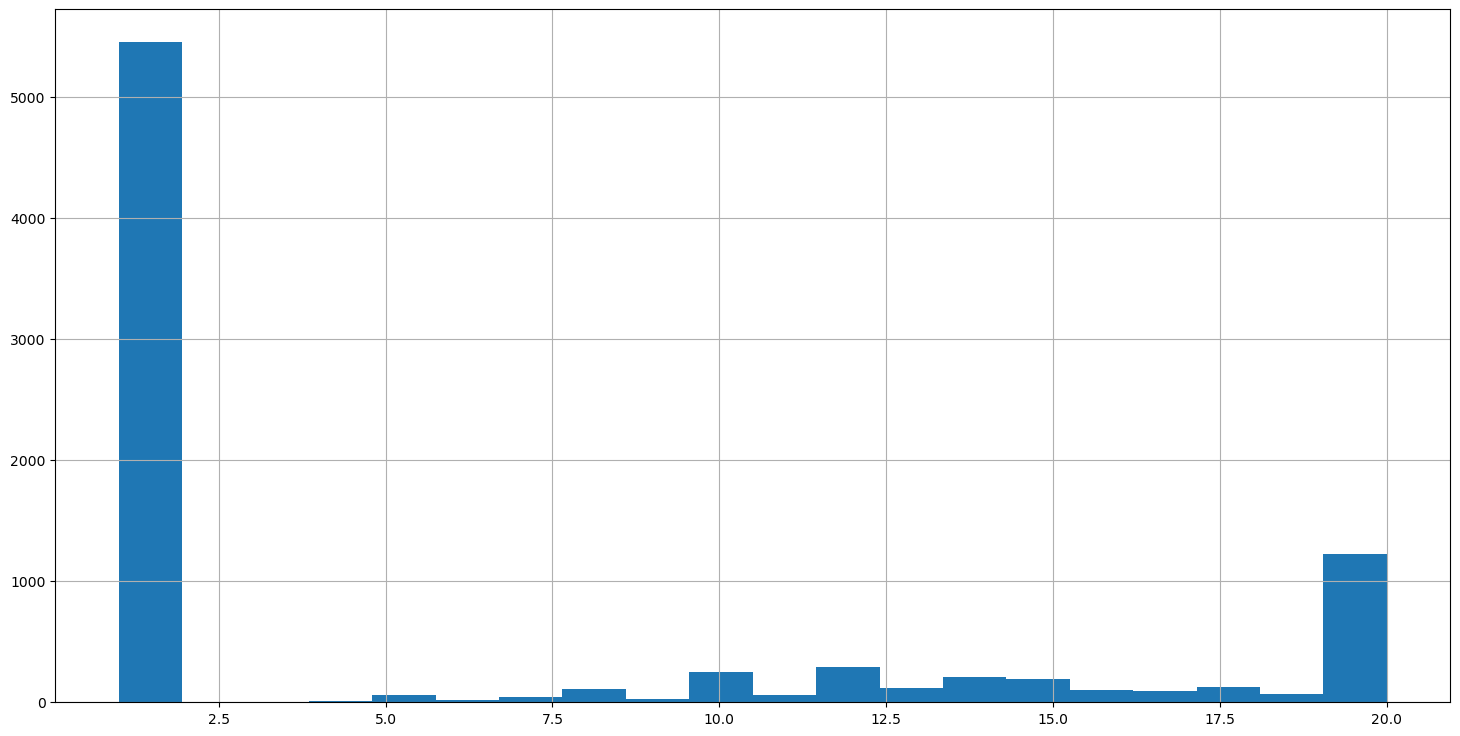

In [5]:
fm_dataset.ST.hist(bins=20)

In [6]:
features = ['Age', 'Corners',
       'Crossing', 'Dribbling', 'Finishing', 'First Touch', 
       'Heading', 'Long Shots',  'Marking', 'Passing',
       'Penalty Taking', 'Tackling', 'Technique', 'Aggressiion',
       'Anticipation', 'Bravery', 'Composure', 'Concentration', 'Vision',
       'Decision', 'Determination',  'Leadership', 'Off The Ball',
       'Teamwork', 'Work Rate', 'Acceleration', 'Agility',
       'Balance', 'Jumping Reach', 'Natural Fitness', 'Pace', 'Stamina',
       'Strength', 'Stability', 'Foul']

classification_labels = ["GK", "DL", "DC", "DR", "WBL", "WBR", "DM", "ML", "MC", "MR", "AML", "AMC", "AMR", "ST"]


features = fm_dataset[features]
classification = fm_dataset[classification_labels]

In [7]:
# Player can play in a position if its skill is >=15
classification[classification<14] = 0
classification[classification>=14] = 1

/var/folders/dp/sb0zbjrn4y70c9_f08rwfmx00000gn/T/ipykernel_12337/2297977626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification[classification<15] = 0
/var/folders/dp/sb0zbjrn4y70c9_f08rwfmx00000gn/T/ipykernel_12337/2297977626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification[classification<15] = 0
/var/folders/dp/sb0zbjrn4y70c9_f08rwfmx00000gn/T/ipykernel_12337/2297977626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [8]:
def evaluate_predictions(labels: List[str], actual_values: np.ndarray, predictions: np.ndarray) -> Tuple[dict, float]:
    """Evaluate the predictions of the model.
    
    Returns a dictionary with the recall, precision and F1-score for each label
    and the overall average F1-score.
    """
    f1_scores = []
    results = {}
    for label, actual, pred in zip(labels, actual_values, predictions):
        results[label] = {"recall": recall_score(actual, pred),
                          "precision": precision_score(actual, pred),
                          "f1-score": f1_score(actual, pred)}
        f1_scores.append(f1_score(actual, pred))
    return results, sum(f1_scores)/len(f1_scores)

In [9]:
scaler = StandardScaler()
kf = KFold(5)

#classifier = KNeighborsClassifier()
classifier = RandomForestClassifier()

all_train_y = None
all_test_y = None
all_train_predictions = None
all_test_predictions = None

for train_index, test_index in kf.split(features):
    
    train_X, train_y = features.loc[train_index], classification.loc[train_index]
    test_X, test_y = features.loc[test_index], classification.loc[test_index]
    
    train_X_scaled = scaler.fit_transform(train_X)
    classifier.fit(train_X, train_y)
    
    train_predictions = classifier.predict(train_X)
    test_predictions = classifier.predict(test_X)
    
    if all_test_y is None:
        all_train_y = train_y.values.T
        all_test_y = test_y.values.T
        all_train_predictions = train_predictions.T
        all_test_predictions = test_predictions.T
    else:
        all_train_y = np.hstack((all_train_y, train_y.values.T))
        all_test_y = np.hstack((all_test_y, test_y.values.T))
        all_train_predictions = np.hstack((all_train_predictions, train_predictions.T))
        all_test_predictions = np.hstack((all_test_predictions, test_predictions.T))

In [10]:
train_results, train_mean_f1_score = evaluate_predictions(classification_labels, all_train_y, all_train_predictions)
test_results, test_mean_f1_score = evaluate_predictions(classification_labels, all_test_y, all_test_predictions)
print(f'Mean train F1-score: {train_mean_f1_score}')
print(f'Mean test F1-score: {test_mean_f1_score}')

with open("resultsRF.json", "w+") as f:
    json.dump(test_results, f, indent=4)

np.savetxt('predictionsRF.txt', all_test_predictions, fmt='%d')

Mean train F1-score: 0.9999862610941664
Mean test F1-score: 0.48218657099668244


In [11]:
scaler = StandardScaler()
classifier = RandomForestClassifier()

train_X, train_y = features.values, classification.values

train_X_scaled = scaler.fit_transform(train_X)
classifier.fit(train_X_scaled, train_y)

pickle.dump(classifier, open("RF.bin", "wb+"))
pickle.dump(scaler, open("scaler.bin", "wb+"))

In [12]:
predictions = np.loadtxt('predictionsRF.txt', dtype=int)
print(predictions.shape)

(14, 8452)


In [13]:
def position_to_text(position, labels):
    """
    Convert a binary list of positions to text describing the position.
    """
    positions_indexes = np.where(position == 1)[0]
    predicted_position = [labels[index] for index in positions_indexes]
    return predicted_position

predicted_positions = [position_to_text(player, classification_labels) for player in predictions.T]
fm_dataset['predicted_positions'] = predicted_positions

In [14]:
players_name = ["Cristiano Ronaldo",
                "Lionel Messi",
                'Lionel Messi',
                'Luka Modrić',
                'Thiago Silva',
                'Toni Kroos',
                'Milan Škriniar',
                "Sergio Ramos",
                "Casemiro",
                "Raphaël Guerreiro"]

for player_name in players_name:
    print(player_name, fm_dataset.loc[fm_dataset['Name'] == player_name].predicted_positions.values[0])

Cristiano Ronaldo ['ST']
Lionel Messi ['AML', 'AMC', 'AMR']
Lionel Messi ['AML', 'AMC', 'AMR']
Luka Modrić ['MC']
Thiago Silva ['DC']
Toni Kroos ['MC', 'AML', 'AMC']
Milan Škriniar ['DC']
Sergio Ramos ['DM', 'MC']
Casemiro ['DM', 'MC']
Raphaël Guerreiro []


In [15]:
# Load classifier and scaler
classifier = pickle.load(open("RF.bin", "rb"))
scaler = pickle.load(open("scaler.bin", "rb"))


In [16]:
attributes = {
"Age": 31,
"Height": 186,
"Weight": 84,
"AerialAbility": 2,
"CommandOfArea": 1,
"Communication": 3,
"Eccentricity": 1,
"Handling": 3,
"Kicking": 2,
"OneOnOnes": 2,
"Reflexes": 3,
"RushingOut": 1,
"TendencyToPunch": 3,
"Throwing": 2,
"Corners": 12,
"Crossing": 14,
"Dribbling": 15,
"Finishing": 19,
"FirstTouch": 16,
"Freekicks": 14,
"Heading": 18,
"LongShots": 19,
"Longthrows": 6,
"Marking": 2,
"Passing": 14,
"PenaltyTaking": 19,
"Tackling": 8,
"Technique": 15,
"Aggression": 6,
"Anticipation": 17,
"Bravery": 16,
"Composure": 13,
"Concentration": 16,
"Vision": 13,
"Decisions": 17,
"Determination": 20,
"Flair": 18,
"OffTheBall": 18,
"Positioning": 5,
"Teamwork": 6,
"Workrate": 7,
"Acceleration": 13,
"Agility": 12,
"Balance": 13,
"Jumping": 16,
"LeftFoot": 15,
"NaturalFitness": 19,
"Pace": 17,
"RightFoot": 20,
"Stamina": 17,
"Strength": 16
}

In [17]:
feat = [[attributes[feature] for feature in features]]
feat = scaler.transform(feat)
prediction = classifier.predict(feat)[0]
predicted_positions = position_to_text(prediction, classification_labels)
positions = ", ".join(predicted_positions) if len(predicted_positions) > 0 else "No Predicted Positions."
print(positions)

KeyError: 'First Touch'